**Transformers:**



*   Transformers are a type of neural network architecture that relies on attention mechanism. The attention mechanism helps the model to learn long-range dependencies between different parts of a sequence.

*   Transformer is composed of two parts: Encoder and decoder. Encoder takes the input sequence and produces hidden states, and the decoder takes the hidden states and produces output sequence.

*   Transformers are now used for variety of natural language processing tasks including machine translation, text summarization and question answering. They have been used for other tasks such as speech recognition and computer vision.




<br>

#Encoder Part: Text classification

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install bertviz
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import load_dataset

In [ ]:
dataset=load_dataset("dair-ai/emotion")
dataset.set_format(type="pandas") #setting the dataset as pandas dataframe

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
df = dataset['train'][:] #the dataset will be displayed in pandas format
df.head() #shows first 5 rows

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
classes = dataset['train'].features['label'].names #trying to get the label names as shown in huggingface
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [ ]:
df['label_name'] = df['label'].apply(lambda x: classes[x]) #apply showing label names for each label
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<br>

#Dataset Analysis
<br>
Dataset analysis is required to undestand more about our dataset and class distribution and overall data distribution.

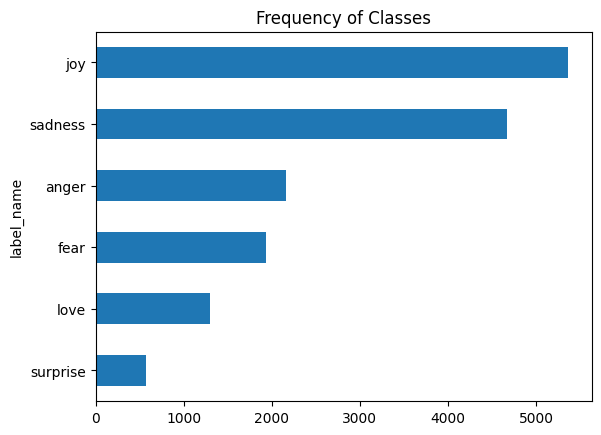

In [ ]:
import matplotlib.pyplot as plt
label_counts =df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title('Frequency of Classes')
plt.show()

In [ ]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)

<Axes: title={'center': 'Words Per Tweet'}, xlabel='label_name'>

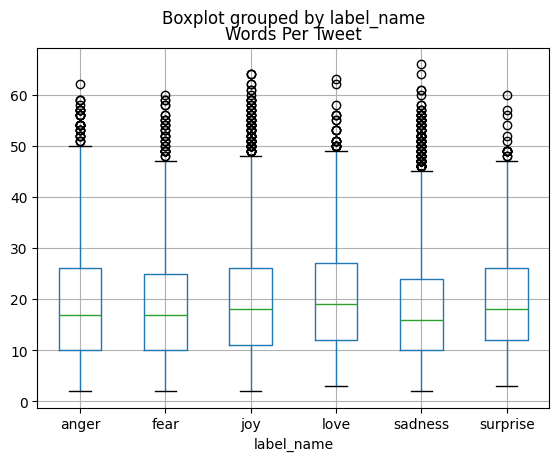

In [ ]:
df.boxplot("Words Per Tweet", by='label_name')

<br>

#Text to Token Conversion

In [ ]:
from transformers import AutoTokenizer #This will automatically fetch the tokenization technique based on the model name
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
text = "Valentine's day. Crying in the hotel bar."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 10113, 1005, 1055, 2154, 1012, 6933, 1999, 1996, 3309, 3347, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


You find 101 and 102 in the list. These are special tokens. 101 marks the start of a sentence (CLS), 102 marks the end of the sentence (separator).

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'valentine', "'", 's', 'day', '.', 'crying', 'in', 'the', 'hotel', 'bar', '.', '[SEP]']


The uppercase in the sentence have been turned to lower case because we are using DistilBERT uncased model.

In [ ]:
tokenizer.vocab_size, tokenizer.model_max_length

(30522, 512)

This displays the total no. of tokens in the dictionary and maximum sequence length of the model.

<br>

#Tokenization of the Emotion Data

In [ ]:
dataset.reset_format() #To work on the whole data in one go.

In [ ]:
#map - tokenization method
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True) #takes a batch of data and applies padding - so all are in same length, truncation - so sequences longer than max length for model are truncated
  return temp

print(tokenize(dataset["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


The result is token IDs of each word (tokenized) and attention mask to show which of them are padding and which is actual data.

<br>

Here we are encoding the dataset. "batched=True, batch_size=None" would mean at one go, train split will pass as a whole data and test split as a whole data.

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

<br>

#Model Building

In [ ]:
text

"Valentine's day. Crying in the hotel bar."

In [ ]:
inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[  101, 10113,  1005,  1055,  2154,  1012,  6933,  1999,  1996,  3309,
          3347,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSelfAttention(
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

The model has multiple layers. Firstly, we find embedding layer that generate embeddings. Then there's transformer that has encoder stack and uses multi-head self attention technique.

In [ ]:
with torch.no_grad():
  outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
last_hidden_states

tensor([[[-0.0219, -0.4122,  0.0835,  ..., -0.3828,  0.4652,  0.0445],
         [-0.6724,  0.1400,  0.3682,  ..., -0.1429,  0.6682, -0.3039],
         [ 0.5900,  0.0677,  0.5227,  ..., -0.4986, -0.1130, -0.6427],
         ...,
         [ 1.0139, -0.1139,  0.6066,  ..., -0.4141,  0.0837, -0.1460],
         [-0.4929, -0.9805,  0.2826,  ...,  0.1030,  0.1612, -0.5971],
         [ 0.8541,  0.1466, -0.1180,  ..., -0.2242, -0.3312, -0.4155]]])

In [ ]:
last_hidden_states.shape

torch.Size([1, 13, 768])

768 - total length of vector generated by DistilBERT
<br>13 - No. of tokens present in the data

*   AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs.


In [ ]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Checks if GPU is available and uses it, if not then uses CPU.
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
model_name = "distilbert-finetuned-emotion-recog"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=64,   # Keep same
    per_device_eval_batch_size=128,   # Increase eval only
    gradient_accumulation_steps=4,    # Effective batch = 256
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False,
    fp16=True,                        # This is the biggest speedup
    dataloader_num_workers=2
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    processing_class=tokenizer  # Changed from tokenizer
)

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 